# 1.4 Divergence

Find the split date that minimizes KL Divergence of critical violation code frequencies.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from research.strings import TARGET, INSPECTION_ID, DATE
from research.utils import get_crit_mat

In [3]:
df = pd.read_csv("data/inspections.csv")
print("Read {} records.".format(len(df)))

Read 18712 records.


In [4]:
SPLIT_DATE = 16252
dfa = df.query("{} < {}".format(DATE, SPLIT_DATE))
dfb = df.query("{} >= {}".format(DATE, SPLIT_DATE))
len(dfa), len(dfb), len(dfa) + len(dfb)
pa = dfa[TARGET].mean()
pb = dfb[TARGET].mean()
kld = stat.entropy([pa, 1 - pa], [pb, 1 - pb])
print("KLD({0}, t={1}) = {2:.3f}".format(TARGET, SPLIT_DATE, kld))

KLD(criticalFound, t=16252) = 0.001


In [5]:
crit_mat = get_crit_mat(df)
VIOLATION_LABELS = list(crit_mat.columns)
crit_mat[INSPECTION_ID] = df[INSPECTION_ID]
merged = df.set_index(INSPECTION_ID).join(crit_mat.set_index(INSPECTION_ID))
merged = merged.reset_index()
merged.head()

,Inspection_ID,criticalFound,Inspection_Date,License,Business_ID,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,269961,0.0,15736,30790,30790-20110416,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,507211,0.0,15265,1475890,1475890-20110416,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,507212,0.0,15265,1740130,1740130-20110216,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,507216,0.0,15266,1447363,1447363-20110216,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,507219,0.0,15267,1679459,1679459-20100216,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Select New Split Date

In [6]:
def kld_split(data, field, t, cols):
    dfa = data.query("{} <= {}".format(field, t))
    dfb = data.query("{} > {}".format(field, t))
    res = []
    for col in cols:
        pa = dfa[col].mean()
        pb = dfb[col].mean()
        kld = stat.entropy([pa, 1 - pa], [pb, 1 - pb])
        res.append(kld)
    return res

In [7]:
kld_target = kld_split(merged, DATE, SPLIT_DATE, [TARGET])[0]
print("KLD({0}, t={1}) = {2:.3f}".format(TARGET, SPLIT_DATE, kld_target))

KLD(criticalFound, t=16252) = 0.001


In [8]:
kld_viols = kld_split(merged, DATE, SPLIT_DATE, VIOLATION_LABELS)
for kld_v, viol_name in zip(kld_viols, VIOLATION_LABELS):
    print("KLD({0}, t={1}) = {2:.3f}".format(viol_name, SPLIT_DATE, kld_v))

KLD(V1, t=16252) = 0.000
KLD(V2, t=16252) = 0.001
KLD(V3, t=16252) = 0.001
KLD(V4, t=16252) = 0.001
KLD(V5, t=16252) = inf
KLD(V6, t=16252) = 0.002
KLD(V7, t=16252) = 0.000
KLD(V8, t=16252) = 0.000
KLD(V9, t=16252) = 0.000
KLD(V10, t=16252) = 0.000
KLD(V11, t=16252) = 0.001
KLD(V12, t=16252) = 0.000
KLD(V13, t=16252) = inf
KLD(V14, t=16252) = inf


In [9]:
SPLIT_VALS = sorted(merged[DATE].unique())

In [10]:
klds_target = [kld_split(merged, DATE, sd, [TARGET])[0] for sd in SPLIT_VALS]

In [11]:
klds_crits = [kld_split(merged, DATE, sd, VIOLATION_LABELS) for sd in SPLIT_VALS]

In [12]:
def earliest_min_split(klds, split_vals):
    return split_vals[np.argmin(klds)]


def latest_min_split(klds, split_vals):
    flipped = np.flip(klds, axis=0)
    min_idx = len(klds) - 1  - np.argmin(flipped)
    return split_vals[min_idx]

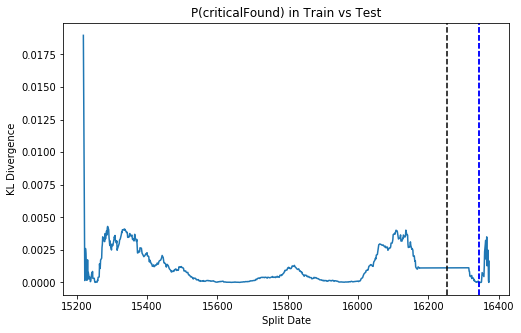

In [13]:
min_split_early = earliest_min_split(klds_target, SPLIT_VALS)
min_split_late = latest_min_split(klds_target, SPLIT_VALS)
sns.lineplot(SPLIT_VALS, klds_target)
plt.axvline(SPLIT_DATE, linestyle="--", color="black")
plt.axvline(min_split_early, linestyle="--", color="blue")
plt.axvline(min_split_late, linestyle="--", color="blue")
plt.xlabel("Split Date")
plt.ylabel("KL Divergence")
plt.title("P({}) in Train vs Test".format(TARGET))
plt.gcf().set_size_inches(8, 5)
plt.show()

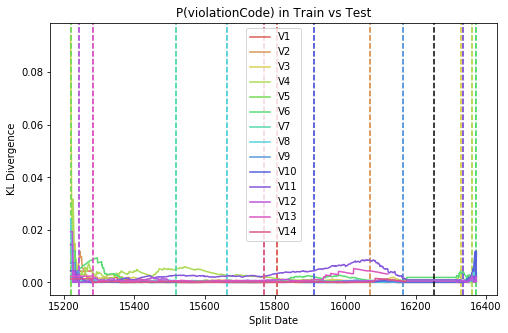

In [14]:
viol_names = VIOLATION_LABELS
pal = sns.hls_palette(len(viol_names))
for i, (viol, color) in enumerate(zip(viol_names, pal)):
    klds_viol = np.array(klds_crits)[:,i]
    min_viol_split_early = earliest_min_split(klds_viol, SPLIT_VALS)
    min_viol_split_late = latest_min_split(klds_viol, SPLIT_VALS)
    plt.axvline(min_viol_split_early, linestyle="--", color=color)
    plt.axvline(min_viol_split_late, linestyle="--", color=color)
    sns.lineplot(SPLIT_VALS, klds_viol, label=viol, color=color)
plt.axvline(SPLIT_DATE, linestyle="--", color="black")
plt.xlabel("Split Date")
plt.ylabel("KL Divergence")
plt.title("P(violationCode) in Train vs Test")
plt.gcf().set_size_inches(8, 5)
plt.show()

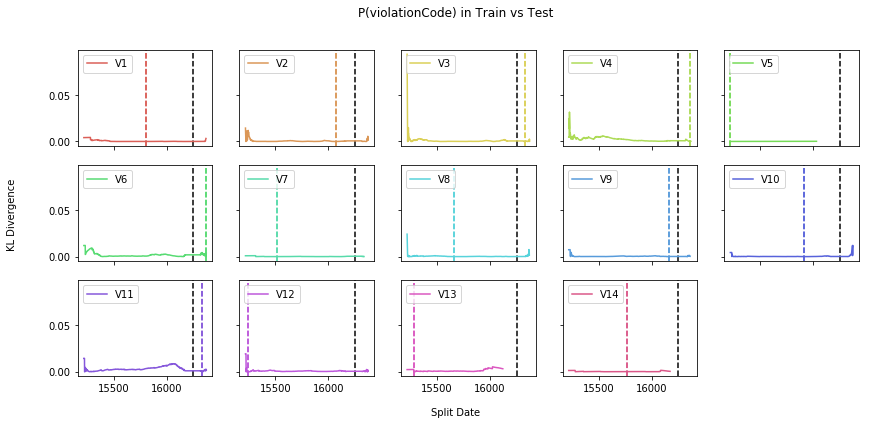

In [15]:
fig, axes = plt.subplots(3, 5, sharex=True, sharey=True)
axes = axes.flatten()
viol_names = VIOLATION_LABELS
pal = sns.hls_palette(len(viol_names))
for i, (viol, color, ax) in enumerate(zip(viol_names, pal, axes)):
    klds_viol = np.array(klds_crits)[:,i]
    min_viol_split_early = earliest_min_split(klds_viol, SPLIT_VALS)
    min_viol_split_late = latest_min_split(klds_viol, SPLIT_VALS)
    ax.axvline(SPLIT_DATE, linestyle="--", color="black")
    ax.axvline(min_viol_split_early, linestyle="--", color=color)
    ax.axvline(min_viol_split_late, linestyle="--", color=color)
    sns.lineplot(SPLIT_VALS, klds_viol, label=viol, color=color, ax=ax)
    ax.legend(loc="upper left")
axes[-1].axis("off")
fig.text(0.5, 0.04, "Split Date", ha="center", va="center")
fig.text(0.06, 0.5, "KL Divergence", ha="center", va="center", rotation="vertical")
fig.suptitle("P(violationCode) in Train vs Test")
fig.set_size_inches(14, 6)
plt.show()

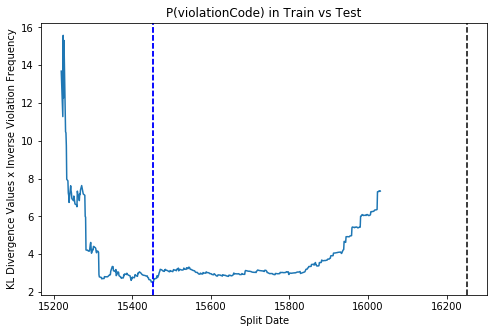

In [31]:
viol_inv_freqs = 1 / crit_mat[VIOLATION_LABELS].mean(axis=0).values
klds_x_inv_freqs = np.dot(np.array(klds_crits), viol_inv_freqs)
min_sum_split_early = earliest_min_split(klds_x_inv_freqs, SPLIT_VALS)
min_sum_split_late = latest_min_split(klds_x_inv_freqs, SPLIT_VALS)
sns.lineplot(SPLIT_VALS, klds_x_inv_freqs)
plt.axvline(SPLIT_DATE, linestyle="--", color="black")
plt.axvline(min_sum_split_early, linestyle="--", color="blue")
plt.axvline(min_sum_split_late, linestyle="--", color="blue")
plt.xlabel("Split Date")
plt.ylabel("KL Divergence Values x Inverse Violation Frequency")
plt.title("P(violationCode) in Train vs Test")
plt.gcf().set_size_inches(8, 5)
plt.show()

In [32]:
early_split = df.query("{} == {}".format(DATE, min_sum_split_early))[DATE].values[0]
late_split = df.query("{} == {}".format(DATE, min_sum_split_late))[DATE].values[0]
early_split_date = df.query("{} == {}".format(DATE, min_sum_split_early))["inspection_date"].values[0]
late_split_date = df.query("{} == {}".format(DATE, min_sum_split_late))["inspection_date"].values[0]
print("Early Min Split = {} = {}".format(early_split, early_split_date))
print("Late Min Split = {} = {}".format(late_split, late_split_date))
best_split = late_split
best_split_date = late_split_date

Early Min Split = 15453 = 2012-04-23T00:00:00.000
Late Min Split = 15453 = 2012-04-23T00:00:00.000


In [33]:
# kld_crit_sum = np.array(klds_crits).sum(axis=1)
# min_sum_split_early = earliest_min_split(kld_crit_sum, SPLIT_VALS)
# min_sum_split_late = latest_min_split(kld_crit_sum, SPLIT_VALS)
# sns.lineplot(SPLIT_VALS, kld_crit_sum)
# plt.axvline(SPLIT_DATE, linestyle="--", color="black")
# plt.axvline(min_sum_split_early, linestyle="--", color="blue")
# plt.axvline(min_sum_split_late, linestyle="--", color="blue")
# plt.xlabel("Split Date")
# plt.ylabel("Sum of KL Divergence Values")
# plt.title("P(violationCode) in Train vs Test")
# plt.gcf().set_size_inches(8, 5)
# plt.show()

In [35]:
# early_split = df.query("{} == {}".format(DATE, min_sum_split_early))[DATE].values[0]
# late_split = df.query("{} == {}".format(DATE, min_sum_split_late))[DATE].values[0]
# early_split_date = df.query("{} == {}".format(DATE, min_sum_split_early))["inspection_date"].values[0]
# late_split_date = df.query("{} == {}".format(DATE, min_sum_split_late))["inspection_date"].values[0]
# print("Early Min Split = {} = {}".format(early_split, early_split_date))
# print("Late Min Split = {} = {}".format(late_split, late_split_date))
# best_split = late_split
# best_split_date = late_split_date

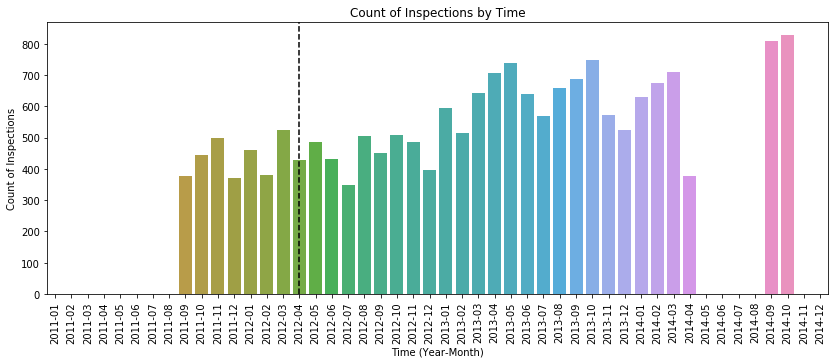

In [36]:
from collections import defaultdict

dts = df["inspection_date"].astype(np.datetime64).apply(lambda dt: dt.strftime("%Y-%m")).value_counts()
year_month_count = defaultdict(lambda: 0)
for year_month, count in zip(dts.index, dts.values):
    year_month_count[year_month] = count
times = []
counts = []
for year in range(2011, 2015):
    for month in range(1, 13):
        year_month = str(year) + "-" + str(month).zfill(2)
        times.append(year_month)
        counts.append(year_month_count[year_month])
split_year_month = pd.to_datetime(best_split_date).strftime("%Y-%m")
plt.axvline(times.index(split_year_month), linestyle="--", color="black")
sns.barplot(times, counts)
plt.xticks(range(len(times)), times, rotation="vertical")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Count of Inspections")
plt.title("Count of Inspections by Time")
plt.gcf().set_size_inches(14, 5)
plt.show()

In [37]:
kld_viols = kld_split(merged, DATE, best_split, [TARGET] + VIOLATION_LABELS)
for kld_v, viol_name in zip(kld_viols, [TARGET] + VIOLATION_LABELS):
    print("KLD({0}, t={1}) = {2:.3f}".format(viol_name, best_split, kld_v))

KLD(criticalFound, t=15453) = 0.001
KLD(V1, t=15453) = 0.001
KLD(V2, t=15453) = 0.000
KLD(V3, t=15453) = 0.000
KLD(V4, t=15453) = 0.002
KLD(V5, t=15453) = 0.000
KLD(V6, t=15453) = 0.001
KLD(V7, t=15453) = 0.000
KLD(V8, t=15453) = 0.001
KLD(V9, t=15453) = 0.000
KLD(V10, t=15453) = 0.000
KLD(V11, t=15453) = 0.002
KLD(V12, t=15453) = 0.002
KLD(V13, t=15453) = 0.000
KLD(V14, t=15453) = 0.000


In [38]:
all_train = merged.query("{} <= {}".format(DATE, best_split))
all_test = merged.query("{} > {}".format(DATE, best_split))
print("Train: N = {0}, P({1}) = {2:.3f}".format(len(all_train), TARGET, all_train[TARGET].mean()))
print("Test:  N = {0}, P({1}) = {2:.3f}".format(len(all_test), TARGET, all_test[TARGET].mean()))

Train: N = 3382, P(criticalFound) = 0.127
Test:  N = 15330, P(criticalFound) = 0.145


In [39]:
for viol_name in VIOLATION_LABELS:
    pa = all_train[viol_name].mean()
    pb = all_test[viol_name].mean()
    na = all_train[viol_name].sum()
    nb = all_test[viol_name].sum()
    print("P({0}, Train) = {1:.3f}\tN = {3}\t\tP({0}, Test) = {2:.3}\tN = {4}".format(viol_name, pa, pb, na, nb))

P(V1, Train) = 0.002	N = 8		P(V1, Test) = 0.00457	N = 70
P(V2, Train) = 0.035	N = 119		P(V2, Test) = 0.0359	N = 550
P(V3, Train) = 0.070	N = 238		P(V3, Test) = 0.0778	N = 1193
P(V4, Train) = 0.009	N = 29		P(V4, Test) = 0.00365	N = 56
P(V5, Train) = 0.000	N = 0		P(V5, Test) = 6.52e-05	N = 1
P(V6, Train) = 0.015	N = 50		P(V6, Test) = 0.0112	N = 172
P(V7, Train) = 0.001	N = 3		P(V7, Test) = 0.000913	N = 14
P(V8, Train) = 0.020	N = 66		P(V8, Test) = 0.0249	N = 381
P(V9, Train) = 0.007	N = 23		P(V9, Test) = 0.0075	N = 115
P(V10, Train) = 0.005	N = 16		P(V10, Test) = 0.00431	N = 66
P(V11, Train) = 0.009	N = 29		P(V11, Test) = 0.0155	N = 238
P(V12, Train) = 0.013	N = 43		P(V12, Test) = 0.0205	N = 314
P(V13, Train) = 0.004	N = 12		P(V13, Test) = 0.00202	N = 31
P(V14, Train) = 0.001	N = 3		P(V14, Test) = 0.00144	N = 22


In [40]:
crit_mat[VIOLATION_LABELS].sum(axis=0)

V1       78
V2      669
V3     1431
V4       85
V5        1
V6      222
V7       17
V8      447
V9      138
V10      82
V11     267
V12     357
V13      43
V14      25
dtype: int64

## Evaluate Impact on Model

In [41]:
from research.evaluation import evaluate_model, show_roc, show_prc
from research.strings import TARGET, PREDICTORS

In [42]:
d_train = df.query("{} <= {}".format(DATE, best_split))
d_test = df.query("{} > {}".format(DATE, best_split))
X_train = d_train[PREDICTORS].values
X_test = d_test[PREDICTORS].values
y_train = d_train[TARGET].values
y_test = d_test[TARGET].values
print("Train: N = {0}, P({1}) = {2:.3f}".format(len(X_train), TARGET, np.mean(y_train)))
print("Test:  N = {0}, P({1}) = {2:.3f}".format(len(X_test), TARGET, np.mean(y_test)))

Train: N = 3382, P(criticalFound) = 0.127
Test:  N = 15330, P(criticalFound) = 0.145


In [43]:
penalties = np.array([1 if "Inspector" in col else 0 for col in PREDICTORS])

In [44]:
from glmnet_python import cvglmnet, cvglmnetPredict, cvglmnetCoef

In [45]:
cvfit = cvglmnet(
    x=X_train.copy(), y=y_train.copy(),
    family="binomial", alpha=0, penalty_factor=penalties, ptype="deviance"
)

/anaconda/lib/python3.6/site-packages/numpy/lib/scimath.py:262: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


In [46]:
BEST_LAMBDA = cvfit["lambda_min"][0]
print("The lambda that minimizes error is: {0:.5f}".format(BEST_LAMBDA))

The lambda that minimizes error is: 0.00219


In [47]:
lam = cvfit["lambda_min"][0]
betas = cvglmnetCoef(cvfit, s=np.array([lam]))
bdf = pd.DataFrame(betas, index=["Intercept"] + PREDICTORS, columns=["Divergence"])
bdf.round(3)

,Divergence
Intercept,-3.171
Inspector_blue,1.165
Inspector_brown,-1.282
Inspector_green,-0.194
Inspector_orange,0.214
Inspector_purple,1.316
Inspector_yellow,-1.735
pastSerious,1.392
pastCritical,-0.146
timeSinceLast,0.408


In [48]:
y_pred_train = cvglmnetPredict(cvfit, newx=X_train, s=np.array([BEST_LAMBDA]), ptype="class").ravel()
y_pred_test = cvglmnetPredict(cvfit, newx=X_test, s=np.array([BEST_LAMBDA]), ptype="class").ravel()

In [49]:
from sklearn.linear_model import LogisticRegression
logres = LogisticRegression(solver="sag")
logres.fit(X_train, y_train)
logres.intercept_ = np.array([betas[0]])
logres.coef_ = np.array([betas[1:]])

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [50]:
evaluate_model(y_test, y_pred_test)

F1 Score = 0.11485
Precision = 0.39267
Recall = 0.06726


,Predicted +,Predicted -
Actual +,150,2080
Actual -,232,12868


In [51]:
evaluate_model(y_test, logres.predict(X_test))

F1 Score = 0.11485
Precision = 0.39267
Recall = 0.06726


,Predicted +,Predicted -
Actual +,150,2080
Actual -,232,12868


In [52]:
model_filename = "models/sklearn-glm-divergence_2012_04_23.pkl"
pickle.dump(logres, open(model_filename, "wb"))
print("Saved model to: {}".format(model_filename))

Saved model to: models/sklearn-glm-divergence_2012_04_23.pkl


In [53]:
city = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, city.predict(X_test))

F1 Score = 0.04296
Precision = 0.51020
Recall = 0.02242


,Predicted +,Predicted -
Actual +,50,2180
Actual -,48,13052


In [54]:
city_betas = [city.intercept_[0][0]] + [a[0] for a in city.coef_[0]]
bdf["City"] = city_betas
bdf["Diff"] = bdf["Divergence"] - bdf["City"]
bdf["SignChange"] = np.sign(bdf["Divergence"]) != np.sign(bdf["City"])
bdf.round(3)

,Divergence,City,Diff,SignChange
Intercept,-3.171,-2.510,-0.661,False
Inspector_blue,1.165,0.950,0.215,False
Inspector_brown,-1.282,-1.306,0.024,False
Inspector_green,-0.194,-0.244,0.050,False
Inspector_orange,0.214,0.202,0.012,False
Inspector_purple,1.316,1.555,-0.238,False
Inspector_yellow,-1.735,-0.697,-1.038,False
pastSerious,1.392,0.302,1.090,False
pastCritical,-0.146,0.427,-0.573,True
timeSinceLast,0.408,0.097,0.311,False


In [55]:
from research.metrics import to_inspection_daynum, compare_metrics

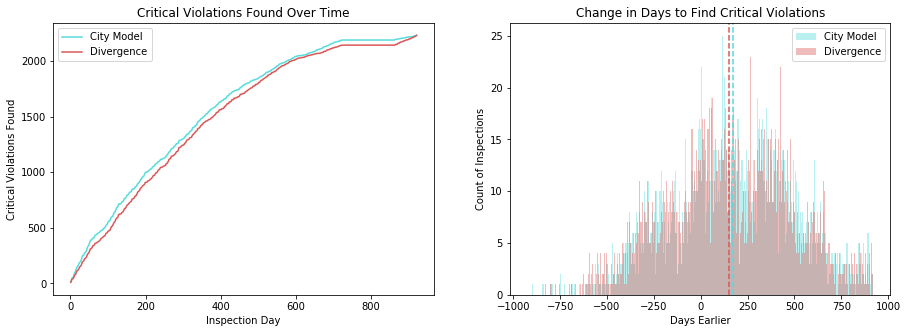

,Model,First Half,Mean Change,Std. Change
0,City Model,0.779,172.812,329.825
1,Divergence,0.748,150.620,331.657


In [56]:
days = to_inspection_daynum(d_test["Inspection_Date"])
compare_metrics(y_test, days, [
    ("City Model", city.predict_proba(X_test)[:,1]),
    ("Divergence", logres.predict_proba(X_test)[:,1])
])

In [57]:
d_test_orig = merged.query("{} > {}".format(DATE, SPLIT_DATE))
X_test_orig = d_test_orig[PREDICTORS]
y_test_orig = d_test_orig[TARGET]
print("Original Test Set: N = {0}, P({1}) = {2:.3f}".format(len(X_test_orig), TARGET, y_test_orig.mean()))

Original Test Set: N = 1637, P(criticalFound) = 0.158


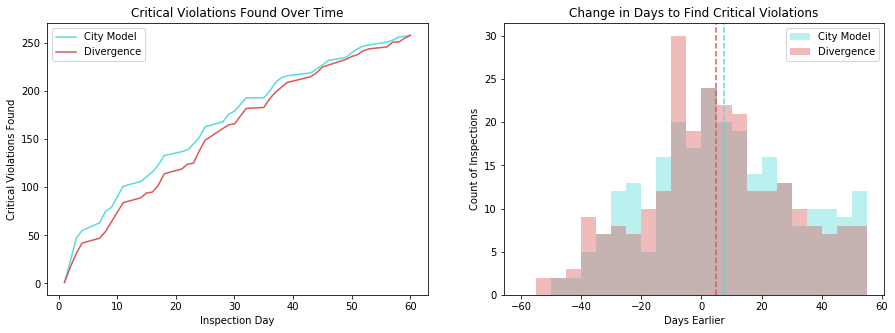

,Model,First Half,Mean Change,Std. Change
0,City Model,0.690,7.438,25.156
1,Divergence,0.643,4.988,24.500


In [58]:
days_orig = to_inspection_daynum(d_test_orig["Inspection_Date"])
compare_metrics(y_test_orig, days_orig, [
    ("City Model", city.predict_proba(X_test_orig)[:,1]),
    ("Divergence", logres.predict_proba(X_test_orig)[:,1])
])